In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import functions.pwdistances as pwdist
import seaborn as sns
import random

In [2]:
vdj = pd.read_csv('data/vdj_cleaned_subset_for_MI.csv', index_col = 0)
vdj = vdj.loc[vdj['Epitope'] != 'KLGGALQAK'] # because too big - takes forever

In [3]:
vdj.head()

,Unnamed: 0,complex.id,Gene-a,CDR3-a,V-a,J-a,Species,MHC A,MHC B,MHC class,...,TCRa,TCRb,cdr1a_IMGTgaps,cdr1b_IMGTgaps,cdr2a_IMGTgaps,cdr2b_IMGTgaps,cdr3a_IMGTgaps,cdr3b_IMGTgaps,len_cdr3a,len_cdr3b
0,13,14,TRA,CAYTVLGNEKLTF,TRAV38-1*01,TRAJ48*01,HomoSapiens,HLA-A*02,B2M,MHCI,...,MTRVSLLWAVVVSTCLESGMAQTVTQSQPEMSVQEAETVTLSCTYD...,MGIRLLCRVAFCFLAVGLVDVKVTQSSRYLVKRTGEKVFLECVQDM...,TSEN-----NYY,MDH-------EN,QEAY--KQQN,SYD----VKM,CAYTVLG--NEKLTF,CASSFTP--YNEQFF,15,15
1,14,15,TRA,CAVAGYGGSQGNLIF,TRAV12-2*01,TRAJ42*01,HomoSapiens,HLA-A*02,B2M,MHCI,...,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,MGIRLLCRVAFCFLAVGLVDVKVTQSSRYLVKRTGEKVFLECVQDM...,DRG------SQS,MDH-------EN,IYS----NGD,SYD----VKM,CAVAGYGGSQGNLIF,CASSPQG-LGTEAFF,15,15
2,15,16,TRA,CAVSFGNEKLTF,TRAV12-2*01,TRAJ48*01,HomoSapiens,HLA-A*02,B2M,MHCI,...,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,MGIRLLCRVAFCFLAVGLVDVKVTQSSRYLVKRTGEKVFLECVQDM...,DRG------SQS,MDH-------EN,IYS----NGD,SYD----VKM,CAVSFG---NEKLTF,CAEGQGF-VGQPQHF,15,15
3,16,17,TRA,CAVTHYGGSQGNLIF,TRAV12-2*01,TRAJ42*01,HomoSapiens,HLA-A*02,B2M,MHCI,...,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,MGIRLLCRVAFCFLAVGLVDVKVTQSSRYLVKRTGEKVFLECVQDM...,DRG------SQS,MDH-------EN,IYS----NGD,SYD----VKM,CAVTHYGGSQGNLIF,CASLRSAVWADTQYF,15,15
4,17,18,TRA,CAGGGGGADGLTF,TRAV12-2*01,TRAJ45*01,HomoSapiens,HLA-A*02,B2M,MHCI,...,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,MGIRLLCRVAFCFLAVGLVDVKVTQSSRYLVKRTGEKVFLECVQDM...,DRG------SQS,MDH-------EN,IYS----NGD,SYD----VKM,CAGGGGG--ADGLTF,CASTLTG-LGQPQHF,15,15


In [4]:
vdj['Epitope'].value_counts()

GILGFVFTL     1894
AVFDRKSDAK    1699
RAKFKQLL      1200
IVTDFSVIK      704
RLRAEAQVK      412
ELAGIGILTV     380
NLVPMVATV      357
SSLENFRAYV     350
GLCTLVAML      345
YLQPRTFLL      333
HGIRNASFI      243
TTDPSFLGRY     242
LLWNGPMAV      235
CINGVCWTV      226
ASNENMETM      201
SSYRRPVGI      177
SPRWYFYYL      175
SSPPMFRV       133
LSLRNPILV      127
ATDALMTGF      125
LTDEMIAQY      124
KSKRTPMGF      103
Name: Epitope, dtype: int64

In [5]:
epdf = vdj[vdj['Epitope'] == 'GLCTLVAML']

In [6]:
As = epdf['CDR3-a'].unique().tolist()
Bs = epdf['CDR3-b'].unique().tolist()

In [7]:
A_sim = pwdist.triplet_similarity(As)
B_sim = pwdist.triplet_similarity(Bs)
dij_A = np.array(A_sim >= 0.76, dtype=int)
dij_B = np.array(B_sim >= 0.72, dtype=int)
np.fill_diagonal(dij_B, 0)
np.fill_diagonal(dij_A, 0)

R[write to console]: Loading required package: kernlab



In [8]:
gA = ig.Graph.Adjacency(dij_A, mode='undirected')
gA.vs['name'] = As
gB = ig.Graph.Adjacency(dij_B, mode='undirected')

In [9]:
clusters = gA.community_multilevel()
modularity_score = gA.modularity(clusters.membership)
print(modularity_score)

clusters = gB.community_multilevel()
modularity_score = gB.modularity(clusters.membership)
print(modularity_score)

0.6943999999999999
0.8436480000000007


To make a-b graph, I have to start over from the sequences and make all edges

In [10]:
A_sim_edges = pd.DataFrame(dij_A, columns=As, index = As).stack().reset_index()
A_sim_edges.columns = ['cdr3a', 'cdr3a_1', 'sim']
Asim = A_sim_edges.loc[A_sim_edges['sim'] == 1]
Aedges = {tuple(sorted(list(x))) for x in zip(Asim['cdr3a'], Asim['cdr3a_1'])}

B_sim_edges = pd.DataFrame(dij_B, columns=Bs, index = Bs).stack().reset_index()
B_sim_edges.columns = ['cdr3b', 'cdr3b_1', 'sim']
Bsim = B_sim_edges.loc[B_sim_edges['sim'] == 1]
Bedges = {tuple(sorted(list(x))) for x in zip(Bsim['cdr3b'], Bsim['cdr3b_1'])}

ABedges = {x for x in zip(epdf['CDR3-a'], epdf['CDR3-b'])}

In [11]:
g = ig.Graph()
g.add_vertices(As, attributes={'color':'blue'})
g.add_edges(Aedges, attributes={'color':'blue', 'weight':10})
g.add_vertices(Bs, attributes={'color':'red'})
g.add_edges(Bedges, attributes={'color':'red', 'weight':10})
g.add_edges(ABedges, attributes={'color':'grey', 'weight':5})

In [12]:
from matplotlib.pyplot import Line2D

/tmp/ipykernel_450122/2263227999.py:8: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  communitiesA = gA.clusters().membership
/tmp/ipykernel_450122/2263227999.py:26: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  communitiesB = gB.clusters().membership


{'0': 0, '1': 1, '2-84-156-181-182-183-210-217': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26-175': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '80': 80, '81': 81, '82': 82, '83': 83, '85': 84, '86': 85, '87': 86, '88': 87, '89': 88, '90': 89, '91': 90, '92': 91, '93': 92, '94': 93, '95': 94, '96': 95, '97': 96, '98': 97, '99': 98

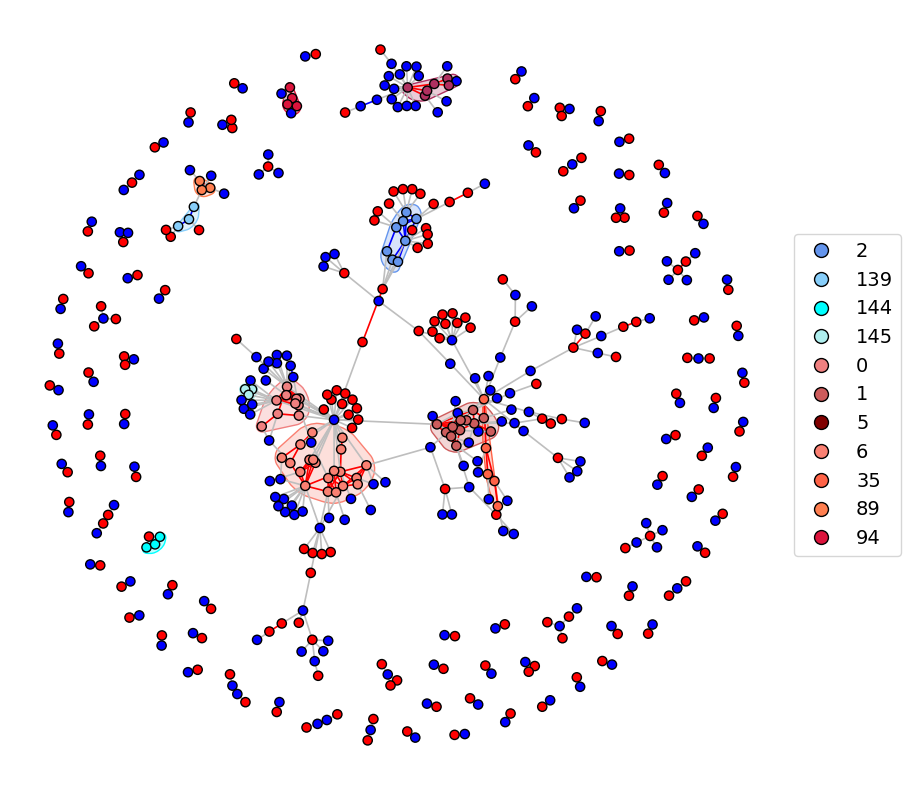

In [13]:
f, ax = plt.subplots(figsize=(10,10))

layout = g.layout(layout='fruchterman_reingold', weights=g.es['weight'])
# ig.plot(g, layout=layout, vertex_size=0.5, edge_width=1.2, 
#         vertex_color = g.vs['color'], edge_color = g.es['color'], target=ax)

# retrieve cluster information so I can mark them on the figure
communitiesA = gA.clusters().membership
cluster_ids = {'-'.join([str(g.vs.find(name=v).index) for v in np.array(As)[np.where(np.array(communitiesA) == xx)]]):xx for xx in set(communitiesA)}
print(cluster_ids)
cluster_seqs = [[v for v in np.array(As)[np.where(np.array(communitiesA) == xx)]] for xx in set(communitiesA)]
cluster_seqs = [x for x in cluster_seqs if len(x) > 2]
clusters_a = [[g.vs.find(name=v).index for v in x] for x in cluster_seqs]
print(clusters_a)
ca = ['cornflowerblue','lightskyblue','cyan','paleturquoise']
colormap_a = list(zip([tuple(x) for x in clusters_a],ca))
colormap1 = dict(zip(['-'.join([str(i) for i in x]) for x in clusters_a],ca))
print(colormap1)
for clus in clusters_a:
    c = colormap1['-'.join(str(i) for i in clus)]
    for x in clus:
        g.vs[x]['color']=c
points_a = [Line2D([0], [0], label=cluster_ids[xx], marker='o', markersize=10, 
         markeredgecolor='k', markerfacecolor=colormap1[xx], linestyle='') for xx in colormap1.keys()]

communitiesB = gB.clusters().membership
cluster_ids = {'-'.join([str(g.vs.find(name=v).index) for v in np.array(Bs)[np.where(np.array(communitiesB) == xx)]]):xx for xx in set(communitiesB)}
print(cluster_ids)
cluster_seqs = [[v for v in np.array(Bs)[np.where(np.array(communitiesB) == xx)]] for xx in set(communitiesB)]
cluster_seqs = [x for x in cluster_seqs if len(x) > 2]
print(cluster_seqs)
clusters_b = [[g.vs.find(name=v).index for v in x] for x in cluster_seqs]
print(clusters_b)
cb = ['lightcoral','indianred','maroon','salmon', 'tomato','coral','crimson']
colormap_b = list(zip([tuple(x) for x in clusters_b],cb))
colormap1 = dict(zip(['-'.join([str(i) for i in x]) for x in clusters_b],cb))
print(colormap1)
for clus in clusters_b:
    c = colormap1['-'.join(str(i) for i in clus)]
    for x in clus:
        g.vs[x]['color']=c

colormap = colormap_a + colormap_b
clusters = clusters_a + clusters_b
cover = ig.VertexCover(g, clusters)
ig.plot(cover,layout=layout, vertex_size=0.5, edge_width=1.2, 
        vertex_color = g.vs['color'], edge_color = g.es['color'], target=ax,
        mark_groups=colormap)

# create custom legend
points_b = [Line2D([0], [0], label=cluster_ids[xx], marker='o', markersize=10, 
         markeredgecolor='k', markerfacecolor=colormap1[xx], linestyle='') for xx in colormap1.keys()]

points = points_a + points_b
plt.legend(points, [x.get_label() for x in points], fontsize=14, bbox_to_anchor=[1,0.5], loc='center left')

plt.savefig('figures/GLC_ab_clustering.png',
                    bbox_inches='tight')
plt.show()

In [14]:
communitiesA = gA.clusters().membership
communitiesA

/tmp/ipykernel_450122/609845043.py:1: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  communitiesA = gA.clusters().membership


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 2,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 144,
 145,
 145,
 145,
 146,
 147,
 148,
 133,
 144,
 149,
 2,
 150,
 151,
 152,
 153,
 154,
 155,
 155,
 156,
 139,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 26,
 166,
 167,
 168,
 169,
 170,
 2,
 2,
 2,
 171,
 172,
 173,

In [15]:
g.vs.find(name='CAEDNNARLMF').index

0

Look at V gene usage in epitope

/tmp/ipykernel_450122/3359044916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epdf['V-b'] = pd.Categorical(epdf['V-b'])
/tmp/ipykernel_450122/3359044916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epdf['V-a'] = pd.Categorical(epdf['V-a'])


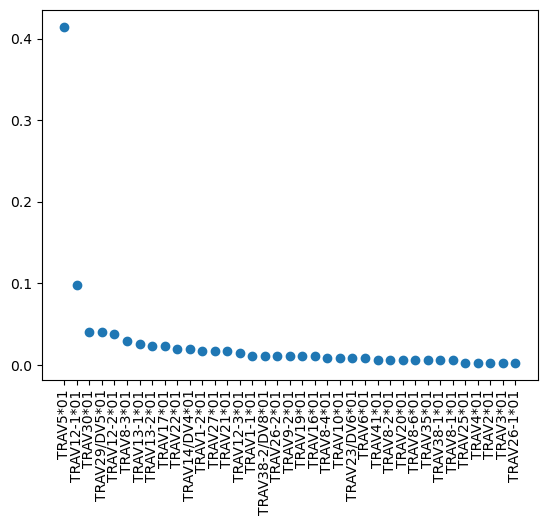

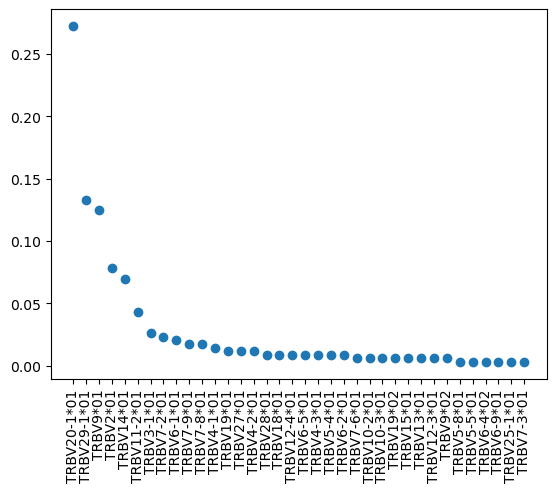

In [16]:
epdf['V-b'] = pd.Categorical(epdf['V-b'])
epdf['V-a'] = pd.Categorical(epdf['V-a'])

baseline_Vb = epdf['V-b'].value_counts()/epdf.shape[0]
baseline_Va = epdf['V-a'].value_counts()/epdf.shape[0]

plt.scatter(x = baseline_Va.index, y = baseline_Va.values)
plt.xticks(baseline_Va.index, rotation=90)
plt.show()

plt.scatter(x = baseline_Vb.index, y = baseline_Vb.values)
plt.xticks(baseline_Vb.index, rotation=90)
plt.show()

Now find communities in alphas and calculate beta similarity

In [17]:
Aclus = gA.clusters().membership
print(Aclus)
Aclus_size = pd.Series(Aclus).value_counts()
largeA = Aclus_size.loc[Aclus_size > 2].index.tolist()
print(largeA)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 2, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 144, 145, 145, 145, 146, 147, 148, 133, 144, 149, 2, 150, 151, 152, 153, 154, 155, 155, 156, 139, 157, 158, 159, 160, 161, 162, 163, 164, 165, 26, 166, 167, 168, 169, 170, 2, 2, 2, 171, 172, 173, 139, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 166, 193, 194, 2, 195, 194, 196, 197, 198, 199, 2, 200, 201, 202, 203, 204, 205, 206,

/tmp/ipykernel_450122/2257141088.py:1: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership


In [18]:
Aclus_size

2      8
145    3
139    3
144    3
166    2
      ..
74     1
75     1
76     1
77     1
209    1
Length: 210, dtype: int64

In [19]:
pairedB = {}
randomB = {}
Va={}
Vb={}

for a in sorted(largeA):
    clus_As = np.array(As)[np.array(Aclus) == a]
    N = epdf.loc[epdf['CDR3-a'].isin(clus_As)].shape[0]
    associatedBs = epdf.loc[epdf['CDR3-a'].isin(clus_As)]['CDR3-b'].tolist()
    print('----------------------------------------------------------------------------')
    print('cluster ID:', a)
    print('alpha sequences', clus_As)
    print('beta sequences:', associatedBs)
    associatedVb = epdf.loc[epdf['CDR3-a'].isin(clus_As)]['V-b'].value_counts()/N
    associatedVa = epdf.loc[epdf['CDR3-a'].isin(clus_As)]['V-a'].value_counts()/N
    remainingBs = epdf.loc[~epdf['CDR3-a'].isin(clus_As)]['CDR3-b'].tolist()
    assB_sim = pwdist.triplet_similarity(associatedBs)

    pairedB[a] = assB_sim[np.triu_indices(assB_sim.shape[0], k = 1)].ravel()
    Vb[str(a) + ',N=' + str(N)] = associatedVb
    Va[str(a) + ',N=' + str(N)] = associatedVa 
    randomB[a] = []
    for i in range(100):
        randomBs = random.choices(remainingBs, k = len(associatedBs))
        randomB_sim = pwdist.triplet_similarity(randomBs)
        randomB[a] = list(randomB[a]) + list(randomB_sim[np.triu_indices(randomB_sim.shape[0], k = 1)].ravel())


----------------------------------------------------------------------------
cluster ID: 2
alpha sequences ['CVVNGKDSSYKLIF' 'CVVNGGDSSYKLIF' 'CVVNGMDSSYKLIF' 'CVVNGMDSSHKLIF'
 'CVVNRDSSYKLIF' 'CVVGMDSSYKLIF' 'CVVNGRDSSYKLIF' 'CVVNGADSSYKLIF']
beta sequences: ['CASSGGAVAPSEQFF', 'CASSEGQVSPGELFF', 'CASTPGTVLPDTQYF', 'CASSGRVLPGELFF', 'CASSGGQLAPGELFF', 'CASSGVQLLPGELFF', 'CASSGVQLLPGELFF', 'CASSGVQLLPGELFF', 'CASSGVQLLPGELFF', 'CASSEGQVLPGEQYF', 'CASSSGQVVPGTIYF', 'CASSPQGVSPGTIYF', 'CASSAPDKAPNEQYF', 'CASSGGRVAPGELFF', 'CASSAGRVLPGEQYF', 'CASSPPEQLPTEAFF', 'CASSEGRVLPGELFF', 'CASSGGQVVPGELFF']
----------------------------------------------------------------------------
cluster ID: 139
alpha sequences ['CASGGSQGNLIF' 'CAAGGSQGNLIF' 'CAASGGSQGNLIF']
beta sequences: ['CASSFGTFETQYF', 'CASSIGTFETQYF', 'CASSVGNEQFF', 'CSSQEGGYGYTF']
----------------------------------------------------------------------------
cluster ID: 144
alpha sequences ['CAVNIDNMDSNYQLIW' 'CAVNIDTMDSNYQLIW' 'CSVNIDTMDS

/tmp/ipykernel_450122/443913101.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(Va_df.index, rotation=90)
/tmp/ipykernel_450122/443913101.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(Vb_df.index, rotation=90)


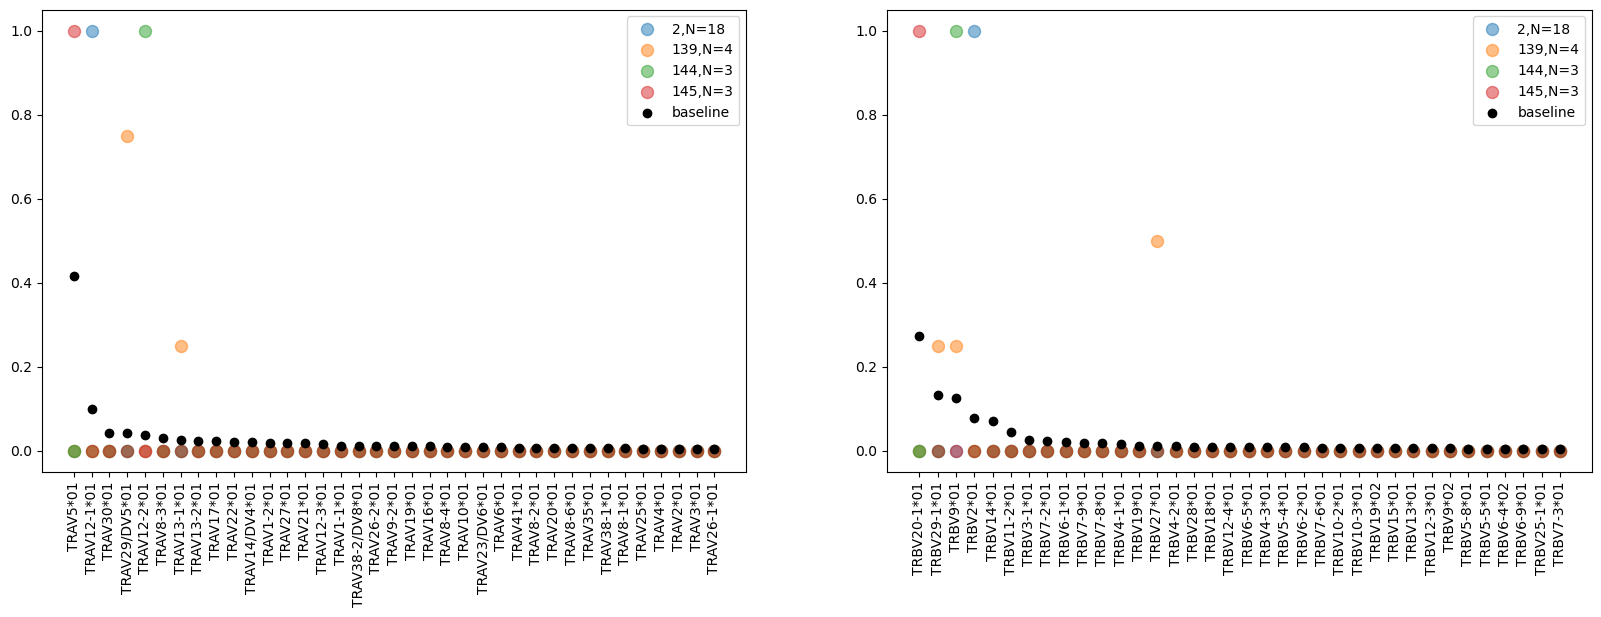

In [20]:
# plot V gene preference when a are clustered

Va_df = pd.DataFrame(Va)
Va_df = pd.merge(Va_df, baseline_Va, left_index=True, right_index=True)
Va_df.columns = Va_df.columns[0:-1].tolist() + ['baseline']
# print(Va_df)
Vb_df = pd.DataFrame(Vb)
Vb_df = pd.merge(Vb_df, baseline_Vb, left_index=True, right_index=True)
Vb_df.columns = Vb_df.columns[0:-1].tolist() + ['baseline']
# print(Vb_df)

Va_df = Va_df.sort_values(by='baseline', ascending=False)
Vb_df = Vb_df.sort_values(by='baseline', ascending=False)

f, ax = plt.subplots(ncols=2, figsize=(20,6))

for a in Va.keys():
    ax[0].scatter(x = Va_df.index, y = Va_df[a], s=75, alpha=0.5, label=a)
    ax[1].scatter(x = Vb_df.index, y = Vb_df[a], s=75, alpha=0.5, label=a)

ax[0].scatter(x = Va_df.index, y = Va_df['baseline'], c = 'k', label = 'baseline')
ax[0].set_xticklabels(Va_df.index, rotation=90)
ax[1].scatter(x = Vb_df.index, y = Vb_df['baseline'], c = 'k', label = 'baseline')
ax[1].set_xticklabels(Vb_df.index, rotation=90)

ax[0].legend()
ax[1].legend()
plt.show()

In [21]:
Bclus = gB.clusters().membership
print(Bclus)
Bclus_size = pd.Series(Bclus).value_counts()
largeB = Bclus_size.loc[Bclus_size > 2].index.tolist()
print(largeB)

[0, 1, 2, 3, 4, 5, 6, 6, 0, 6, 7, 8, 6, 6, 9, 10, 11, 6, 12, 13, 14, 15, 0, 16, 17, 18, 19, 5, 20, 6, 21, 6, 22, 23, 24, 6, 1, 25, 26, 27, 28, 29, 30, 6, 6, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 0, 41, 39, 42, 43, 44, 45, 46, 9, 47, 48, 49, 50, 51, 5, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 6, 72, 73, 74, 75, 76, 76, 77, 78, 79, 80, 81, 0, 0, 82, 0, 0, 0, 0, 83, 83, 84, 1, 85, 86, 87, 87, 5, 5, 5, 88, 1, 1, 1, 89, 90, 91, 91, 1, 92, 34, 93, 94, 94, 94, 95, 96, 96, 97, 97, 63, 98, 98, 99, 100, 94, 101, 102, 103, 104, 105, 106, 107, 108, 89, 109, 110, 111, 6, 112, 113, 114, 115, 116, 117, 118, 119, 1, 120, 121, 122, 123, 124, 125, 126, 126, 127, 3, 128, 129, 130, 131, 132, 1, 1, 133, 134, 135, 136, 137, 6, 6, 138, 139, 140, 141, 6, 142, 35, 143, 6, 144, 145, 146, 147, 148, 149, 150, 35, 151, 152, 153, 1, 154, 155, 156, 35, 157, 141, 139, 6, 89, 158, 115, 159, 160, 161, 6, 162, 1, 163, 164, 165, 166, 35, 167, 168, 6, 169]
[6, 1, 0, 5, 35, 94, 89]


/tmp/ipykernel_450122/2276775239.py:1: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


In [22]:
pairedA = {}
Vb = {}
Va = {}
randomA = {}

for b in largeB:
    # print(np.array(Aclus) == a)
    clus_Bs = np.array(Bs)[np.array(Bclus) == b]
    N = epdf.loc[epdf['CDR3-b'].isin(clus_Bs)].shape[0]
    associatedAs = epdf.loc[epdf['CDR3-b'].isin(clus_Bs)]['CDR3-a'].tolist()
    associatedVb = epdf.loc[epdf['CDR3-b'].isin(clus_Bs)]['V-b'].value_counts()/N
    associatedVa = epdf.loc[epdf['CDR3-b'].isin(clus_Bs)]['V-a'].value_counts()/N
    remainingAs = epdf.loc[~epdf['CDR3-b'].isin(clus_Bs)]['CDR3-a'].tolist()
    print('----------------------------------------------------------------------------')
    print('cluster ID:', b)
    print('beta sequences', clus_Bs)
    print('alpha sequences:', associatedAs)
    assA_sim = pwdist.triplet_similarity(associatedAs)
    pairedA[b] = assA_sim[np.triu_indices(assA_sim.shape[0], k = 1)].ravel() 
    Vb[str(b) + ',N=' + str(N)] = associatedVb
    Va[str(b) + ',N=' + str(N)] = associatedVa
    randomA[b] = []
    for i in range(100):
        randomAs = random.choices(remainingAs, k = len(associatedAs))
        randomA_sim = pwdist.triplet_similarity(randomAs)
        randomA[b] = list(randomA[b]) + list(randomA_sim[np.triu_indices(randomA_sim.shape[0], k = 1)].ravel())
        print('random alpha sequences:', randomAs)
    

----------------------------------------------------------------------------
cluster ID: 6
beta sequences ['CSARVGVGNTIYF' 'CSARTGVGNTIYF' 'CSARDRIGNTIYF' 'CSARSGVGNTIYF'
 'CSARWGVGNTIYF' 'CSARIGVGNTIYF' 'CSARDETGNTIYF' 'CSARVGPTGNTIYF'
 'CSARSETGNTIYF' 'CSARSRVGNTIYF' 'CSARDRVGNTIYF' 'CSARDREFGNTIYF'
 'CSARDRGSGNTIYF' 'CSARSHVGNTIYF' 'CSARDQTGNTIYF' 'CSARSQVGNTIYF'
 'CSARDEVGNTIYF' 'CSARDRGIGNTIYF' 'CSARVRPTGNTIYF' 'CSARSDVGNTIYF']
alpha sequences: ['CAEDNNARLMF', 'CAEDFNARLMF', 'CAEDKDARLMF', 'CAEDSNARLMF', 'CAEDQNARLMF', 'CAEDNNARLMF', 'CAEDNNARLMF', 'CAEDNNARLMF', 'CAEDNNARLMF', 'CAEDSNARLMF', 'CAEDSNARLMF', 'CAEDFNARLMF', 'CADSGGGADGLTF', 'CAAASNFGNEKLTF', 'CAMKSTNAGKSTF', 'CAVRADSGAGSYQLTF', 'CAGMNRDDKIIF', 'CAVSDPRTGANNLFF', 'CVVSDVNTDKLIF', 'CAVGLFNFNKFYF', 'CAEDNNARLMF', 'CAADSNARFMF', 'CAADSNARLMF', 'CAEDNNARLMF', 'CAEGHDSTLTF', 'CAEDRNARLMF', 'CAEDANARLMF', 'CAEDRNARLMF', 'CAEDNNARLMF', 'CAEDDNARLMF', 'CAEDNNARLMF', 'CAEDNNARLMF', 'CADDSNARLMF']
random alpha sequences: ['CAE

/tmp/ipykernel_450122/503584149.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(Va_df.index, rotation=90)
/tmp/ipykernel_450122/503584149.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(Vb_df.index, rotation=90)


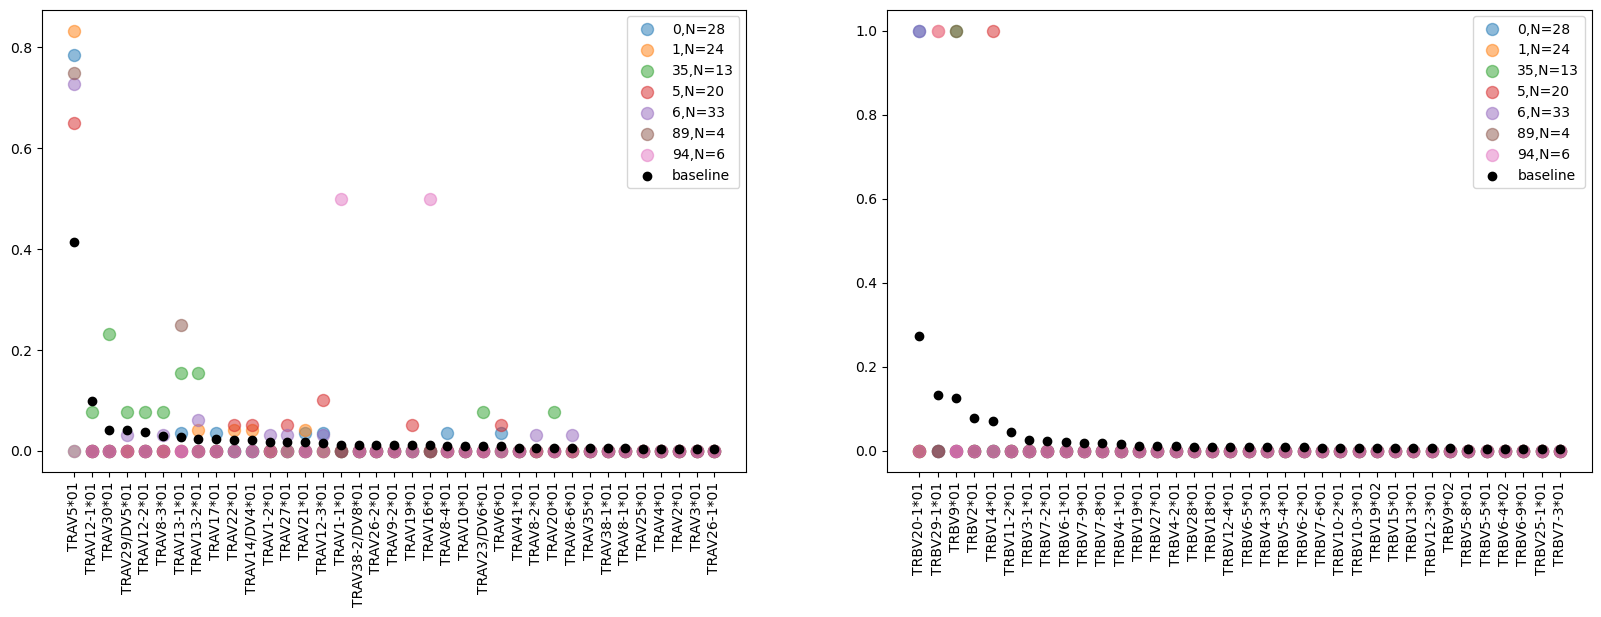

In [23]:
# plot V gene preference when b are clustered

Va_df = pd.DataFrame(Va)
Va_df = pd.merge(Va_df, baseline_Va, left_index=True, right_index=True)
Va_df.columns = Va_df.columns[0:-1].tolist() + ['baseline']
# print(Va_df)
Vb_df = pd.DataFrame(Vb)
Vb_df = pd.merge(Vb_df, baseline_Vb, left_index=True, right_index=True)
Vb_df.columns = Vb_df.columns[0:-1].tolist() + ['baseline']
# print(Vb_df)

Va_df = Va_df.sort_values(by='baseline', ascending=False)
Vb_df = Vb_df.sort_values(by='baseline', ascending=False)

f, ax = plt.subplots(ncols=2, figsize=(20,6))

for b in sorted(list(Va.keys())):
    # print(A)
    # print(B)
    ax[0].scatter(x = Va_df.index, y = Va_df[b], s=75, alpha=0.5, label=b)
    ax[1].scatter(x = Vb_df.index, y = Vb_df[b], s=75, alpha=0.5, label=b)

ax[0].scatter(x = Va_df.index, y = Va_df['baseline'], c = 'k', label = 'baseline')
ax[0].set_xticklabels(Va_df.index, rotation=90)
ax[1].scatter(x = Vb_df.index, y = Vb_df['baseline'], c = 'k', label = 'baseline')
ax[1].set_xticklabels(Vb_df.index, rotation=90)

ax[0].legend()
ax[1].legend()
plt.show()

In [24]:
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches

[2, 139, 144, 145]
[3.0105956455850476e-51, 0.21225859301936856, 8.793030454807955e-19, 3.0532096139911096e-20]
['\n***', '\n', '\n***', '\n***']
[0, 1, 5, 6, 35, 89, 94]
[8.121346620589042e-111, 2.5145963178838023e-149, 0.12547478466249287, 0.0, 0.8111659736173913, 0.0457083011962257, 7.843928742117419e-57]
['\n***', '\n***', '\n', '\n***', '\n', '\n*', '\n***']


/tmp/ipykernel_450122/1988463923.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_tests = [ttest_ind(pairedB[x],randomB[x],alternative='greater').pvalue for x in X]


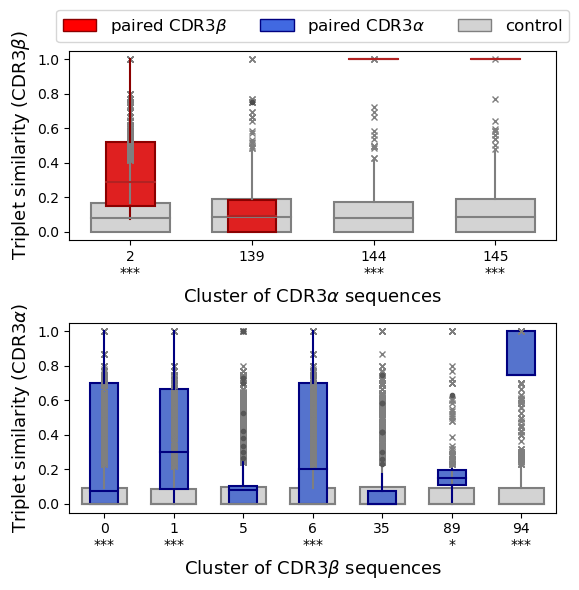

In [25]:
# plot sequence similarity when sequences are clustered (both a and b)

f, ax = plt.subplots(nrows=2, figsize = (6, 6), sharey=True)

X = sorted([x for x in pairedB.keys()])
print(X)
sns.boxplot([randomB[x] for x in X], color='lightgrey', width=0.65,
            notch=False, showcaps=False,
            flierprops={"marker": "x"},
            medianprops={"color": "grey"}, ax = ax[0])
# sns.stripplot([x for x in pairedB.values()], color='grey')
sns.boxplot([pairedB[x] for x in X], color='r', width=0.4,
            notch=False, showcaps=False, fliersize = 3,
            boxprops = {'edgecolor':'darkred'},
            whiskerprops = {'color':'darkred'},
            flierprops={"marker": "o"},
            medianprops={"color": "firebrick"}, ax = ax[0])
t_tests = [ttest_ind(pairedB[x],randomB[x],alternative='greater').pvalue for x in X]
print(t_tests)
pvals = ['\n***' if x <0.001 else '\n**' if x <0.01 else '\n*' if x<0.05 else '\n' for x in t_tests]
print(pvals)
labs = [str(X[x]) + pvals[x] for x in range(len(X))]
# sns.stripplot([x for x in pairedB.values()], color='red')
ax[0].set_xticks(ticks = list(range(len(X))), labels = labs)
ax[0].set_xlabel(r'Cluster of CDR3$\alpha$ sequences', fontsize=13)
ax[0].set_ylabel(r'Triplet similarity (CDR3$\beta$)', fontsize=13)

X = sorted([x for x in pairedA.keys()])
print(X)
sns.boxplot([randomA[x] for x in X], color='lightgrey', width=0.65,
            notch=False, showcaps=False,
            flierprops={"marker": "x"},
            medianprops={"color": "grey"}, ax = ax[1])
# sns.stripplot([x for x in pairedA.values()], color='grey')
g = sns.boxplot([pairedA[x] for x in X], color='royalblue', width=0.4,
            notch=False, showcaps=False, fliersize = 3,
            boxprops = {'edgecolor':'navy'},
            whiskerprops = {'color':'navy'},
            flierprops={"marker": "o"},
            medianprops={"color": "navy"}, ax = ax[1])

red_patch = mpatches.Patch(facecolor='red', edgecolor = 'darkred', label=r'paired CDR3$\beta$')
blue_patch = mpatches.Patch(facecolor='royalblue', edgecolor = 'navy', label=r'paired CDR3$\alpha$')
grey_patch = mpatches.Patch(facecolor='lightgrey', edgecolor = 'grey', label=r'control')
ax[0].legend(handles=[red_patch, blue_patch, grey_patch], bbox_to_anchor = [0.5,1], 
            loc = 'lower center', ncols = 3, fontsize = 12)

# sns.stripplot([x for x in pairedA.values()], color='red')
t_tests = [ttest_ind(pairedA[x],randomA[x],alternative='greater').pvalue for x in X]
print(t_tests)
pvals = ['\n***' if x <0.001 else '\n**' if x <0.01 else '\n*' if x<0.05 else '\n' for x in t_tests]
print(pvals)
labs = [str(X[x]) + pvals[x] for x in range(len(X))]
ax[1].set_xticks(ticks = list(range(len(X))), labels = labs)
ax[1].set_xlabel(r'Cluster of CDR3$\beta$ sequences', fontsize = 13)
ax[1].set_ylabel(r'Triplet similarity (CDR3$\alpha$)', fontsize=13)
plt.tight_layout()
plt.savefig('figures/GLC_ab_clustering_seqsim.png',
                    bbox_inches='tight')
plt.show()

Now I repeat systematically for all epitopes (but only taking medians)

In [26]:
pairedA = {}
randomA = {}
pairedB = {}
randomB = {}
modularity = {}

for ep in vdj['Epitope'].unique():
    print(ep)
    epdf = vdj[vdj['Epitope'] == ep]
    As = epdf['CDR3-a'].unique().tolist()
    Bs = epdf['CDR3-b'].unique().tolist()

    print('calculate similarity...')
    A_sim = pwdist.triplet_similarity(As)
    B_sim = pwdist.triplet_similarity(Bs)
    dij_A = np.array(A_sim >= 0.76, dtype=int)
    dij_B = np.array(B_sim >= 0.72, dtype=int)
    np.fill_diagonal(dij_B, 0)
    np.fill_diagonal(dij_A, 0)

    gA = ig.Graph.Adjacency(dij_A, mode='undirected')
    gB = ig.Graph.Adjacency(dij_B, mode='undirected')

    clusters = gA.community_multilevel()
    modularity_scoreA = gA.modularity(clusters.membership)

    clusters = gB.community_multilevel()
    modularity_scoreB = gB.modularity(clusters.membership)
    modularity[ep] = {'a':modularity_scoreA, 'b':modularity_scoreB}

    print('looking at A clusters...')
    Aclus = gA.clusters().membership
    Aclus_size = pd.Series(Aclus).value_counts()
    largeA = Aclus_size.loc[Aclus_size > 2].index.tolist()

    pairedB[ep] = {}
    randomB[ep] = {}

    for a in largeA:
        # print(np.array(Aclus) == a)
        clus_As = np.array(As)[np.array(Aclus) == a]
        associatedBs = epdf.loc[epdf['CDR3-a'].isin(clus_As)]['CDR3-b'].tolist()
        remainingBs = epdf.loc[~epdf['CDR3-a'].isin(clus_As)]['CDR3-b'].tolist()
        assB_sim = pwdist.triplet_similarity(associatedBs)

        pairedB[ep][a] = np.median(assB_sim[np.triu_indices(assB_sim.shape[0], k = 1)].ravel())
        randomB[ep][a] = []
        for i in range(100):
            randomBs = random.choices(remainingBs, k = len(associatedBs))
            randomB_sim = pwdist.triplet_similarity(randomBs)
            randomB[ep][a].append(np.median(randomB_sim[np.triu_indices(randomB_sim.shape[0], k = 1)].ravel()))
        
    
    Bclus = gB.clusters().membership
    Bclus_size = pd.Series(Bclus).value_counts()
    largeB = Bclus_size.loc[Bclus_size > 2].index.tolist()

    print('looking at B clusters...')
    pairedA[ep] = {}
    randomA[ep] = {}

    for b in largeB:
        # print(np.array(Aclus) == a)
        clus_Bs = np.array(Bs)[np.array(Bclus) == b]
        associatedAs = epdf.loc[epdf['CDR3-b'].isin(clus_Bs)]['CDR3-a'].tolist()
        remainingAs = epdf.loc[~epdf['CDR3-b'].isin(clus_Bs)]['CDR3-a'].tolist()
        # print(randomBs)
        assA_sim = pwdist.triplet_similarity(associatedAs)
        pairedA[ep][b] = np.median(assA_sim[np.triu_indices(assA_sim.shape[0], k = 1)].ravel())
        randomA[ep][b] = []
        for i in range(100):
            randomAs = random.choices(remainingAs, k = len(associatedAs))
            randomA_sim = pwdist.triplet_similarity(randomAs)
            randomA[ep][b].append(np.median(randomA_sim[np.triu_indices(randomA_sim.shape[0], k = 1)].ravel()))
        
        
    

ELAGIGILTV
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
GILGFVFTL
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
NLVPMVATV
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
GLCTLVAML
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
SSLENFRAYV
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
ASNENMETM
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
YLQPRTFLL
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
LLWNGPMAV
calculate similarity...
looking at A clusters...
looking at B clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


CINGVCWTV
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
KSKRTPMGF
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
ATDALMTGF
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
AVFDRKSDAK
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
IVTDFSVIK
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
RAKFKQLL
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
RLRAEAQVK
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
HGIRNASFI
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
SSPPMFRV
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
LSLRNPILV
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
SSYRRPVGI
calculate similarity...
looking at A clusters...
looking at B clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


LTDEMIAQY
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


looking at B clusters...
TTDPSFLGRY
calculate similarity...
looking at A clusters...
looking at B clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership
/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


SPRWYFYYL
calculate similarity...
looking at A clusters...


/tmp/ipykernel_450122/1504727807.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Aclus = gA.clusters().membership


looking at B clusters...


/tmp/ipykernel_450122/1504727807.py:54: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  Bclus = gB.clusters().membership


In [27]:
DF = pd.DataFrame()

for ep in pairedA.keys():
    print(ep)
    
    for c in pairedA[ep].keys():
        X = pd.DataFrame(pd.Series(pairedA[ep][c]))
        Y = pd.DataFrame(pd.Series(randomA[ep][c]))
        X['set'] = 'real'
        X['clus'] = c
        X['ep'] = ep
        Y['set'] = 'random'
        Y['clus'] = c
        Y['ep'] = ep
        X['chain'] = 'a'
        Y['chain'] = 'a'
        DF = pd.concat([DF, X,Y])
    
    for c in pairedB[ep].keys():
        X = pd.DataFrame(pd.Series(pairedB[ep][c]))
        Y = pd.DataFrame(pd.Series(randomB[ep][c]))
        X['set'] = 'real'
        X['clus'] = c
        X['ep'] = ep
        Y['set'] = 'random'
        Y['clus'] = c
        Y['ep'] = ep
        X['chain'] = 'b'
        Y['chain'] = 'b'
        DF = pd.concat([DF, X,Y])


ELAGIGILTV
GILGFVFTL
NLVPMVATV
GLCTLVAML
SSLENFRAYV
ASNENMETM
YLQPRTFLL
LLWNGPMAV
CINGVCWTV
KSKRTPMGF
ATDALMTGF
AVFDRKSDAK
IVTDFSVIK
RAKFKQLL
RLRAEAQVK
HGIRNASFI
SSPPMFRV
LSLRNPILV
SSYRRPVGI
LTDEMIAQY
TTDPSFLGRY
SPRWYFYYL


In [28]:
# # not included in thesis

# cat = pd.CategoricalDtype(['b', 'a'])
# DF['chain'] = DF['chain'].astype(cat)

# ax = plt.subplot()

# sns.boxplot(DF.loc[DF['set'] == 'random'], x = 'chain', y = 0,
#             color='lightgrey', width=0.65, showfliers=False,
#             notch=False, showcaps=False,
#             flierprops={"marker": "x"},
#             medianprops={"color": "grey"}, ax = ax)
# sns.boxplot(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'b')], x = 'chain', y = 0,
#             color='r', width=0.4,
#             notch=False, showcaps=False, showfliers=False,
#             boxprops = {'edgecolor':'darkred'},
#             whiskerprops = {'color':'darkred'},
#             flierprops={"marker": "o"},
#             medianprops={"color": "firebrick"}, ax = ax)
# sns.stripplot(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'b')], x = 'chain', y = 0,
#             color='darkred', ax = ax)
# sns.boxplot(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'a')], x = 'chain', y = 0,
#             color='royalblue', width=0.4,
#             notch=False, showcaps=False, showfliers=False,
#             boxprops = {'edgecolor':'navy'},
#             whiskerprops = {'color':'navy'},
#             flierprops={"marker": "o"},
#             medianprops={"color": "navy"}, ax = ax)
# sns.stripplot(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'a')], x = 'chain', y = 0,
#             color='navy', ax = ax)

# ax.set_xticklabels(labels=[r'$\beta$', r'$\alpha$'], fontsize = 14)
# ax.set_xlabel(r'Paired chain', fontsize = 14)
# ax.set_ylabel(r'Median triplet similarity of paired CDR3s', fontsize=14)
# plt.tight_layout()
# plt.show()

In [29]:
print(DF)

           0     set  clus          ep chain
0   0.074125    real     4  ELAGIGILTV     a
0   0.091098  random     4  ELAGIGILTV     a
1   0.130744  random     4  ELAGIGILTV     a
2   0.087039  random     4  ELAGIGILTV     a
3   0.095346  random     4  ELAGIGILTV     a
..       ...     ...   ...         ...   ...
95  0.000000  random    52   SPRWYFYYL     b
96  0.077850  random    52   SPRWYFYYL     b
97  0.140028  random    52   SPRWYFYYL     b
98  0.138013  random    52   SPRWYFYYL     b
99  0.069007  random    52   SPRWYFYYL     b

[24341 rows x 5 columns]


/tmp/ipykernel_450122/4206931084.py:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_tests = [ttest_ind(DF.loc[(DF['set'] == 'random') & (DF['chain'] == 'b') & (DF['ep'] == ep)][0],
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


[1.018675812029531e-15, nan, 0.03522879579338021, 0.00034777708052196904, 0.5606351956061788, 0.016796812337791844, 3.893219268227114e-26, 0.09367243288867459, 0.42158293677259845, 2.5909577784534024e-31, nan, 3.9677682210448945e-07, 3.995289646194371e-11, 1.9529712192248315e-09, 0.0030524216939222864, 0.09768193975195284, 0.06189045934671192, 9.697093119399004e-07, 0.0006733959441806778, nan, nan, 0.00961273207777007]
['\n***', '\n', '\n*', '\n***', '\n', '\n*', '\n***', '\n', '\n', '\n***', '\n', '\n***', '\n***', '\n***', '\n**', '\n', '\n', '\n***', '\n***', '\n', '\n', '\n**']


/tmp/ipykernel_450122/4206931084.py:54: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_tests = [ttest_ind(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'a') & (DF['ep'] == ep)][0],
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


[4.3592846979032136e-30, 6.460150141640113e-46, 0.14671076731818936, 0.0009922536885730573, 0.16538552942211732, 7.124574627075463e-09, 2.525930727180192e-37, 3.768254962258424e-05, nan, 1.2591439015195473e-07, 0.14903609886656866, 0.41633707094002137, nan, 7.502011078721164e-35, 0.0001467738835058652, nan, nan, 7.774639959015557e-14, nan, 5.983458270578724e-13, 7.203866013894315e-08, 9.701688199262254e-08]


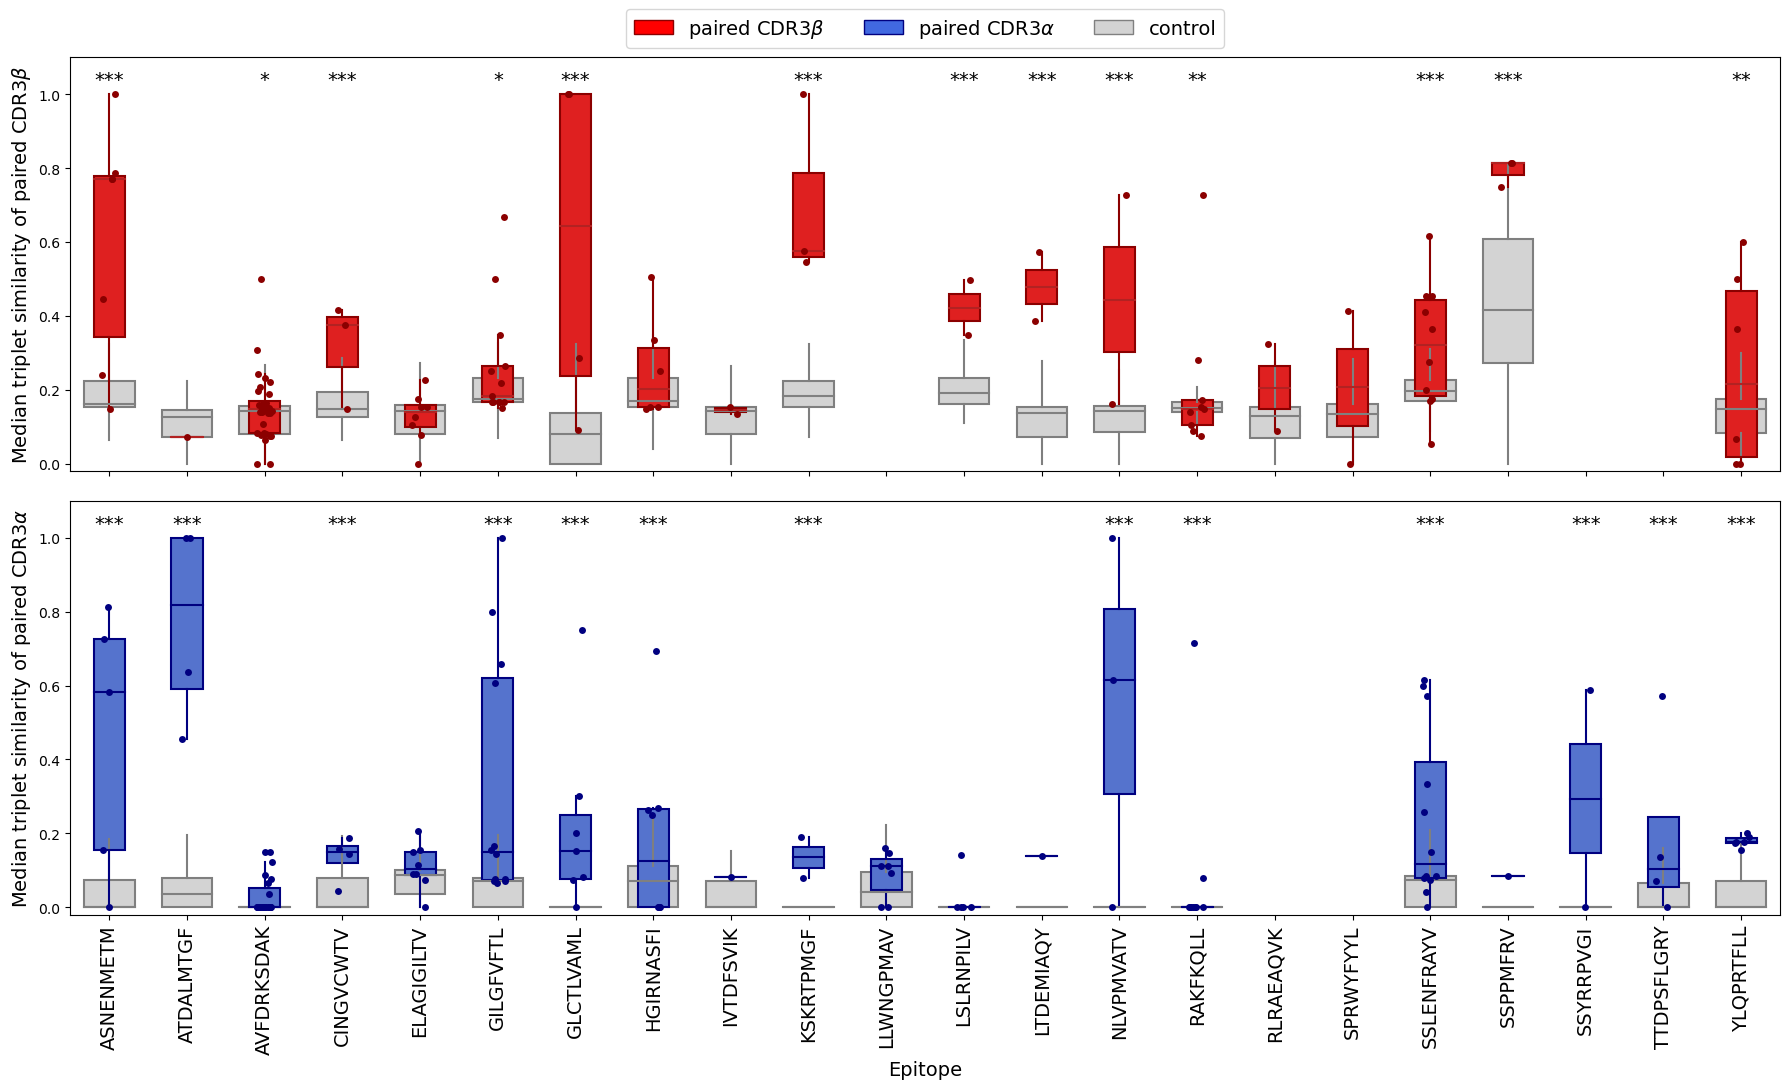

In [30]:
cat = pd.CategoricalDtype(['b', 'a'])
DF['chain'] = DF['chain'].astype(cat)
cats = sorted(vdj['Epitope'].unique().tolist())
cat1 = pd.CategoricalDtype(cats)
DF['ep'] = DF['ep'].astype(cat1)

f,ax = plt.subplots(nrows=2, figsize=(18, 11), sharex=True)

sns.boxplot(DF.loc[(DF['set'] == 'random') & (DF['chain'] == 'b')], x = 'ep', y = 0,
            color='lightgrey', width=0.65, showfliers=False,
            notch=False, showcaps=False,
            flierprops={"marker": "x"},
            medianprops={"color": "grey"}, ax = ax[0])
sns.boxplot(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'b')], x = 'ep', y = 0,
            color='r', width=0.4,
            notch=False, showcaps=False, showfliers=False,
            boxprops = {'edgecolor':'darkred'},
            whiskerprops = {'color':'darkred'},
            flierprops={"marker": "o"},
            medianprops={"color": "firebrick"}, ax = ax[0])
sns.stripplot(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'b')], x = 'ep', y = 0,
            color='darkred', ax = ax[0])
t_tests = [ttest_ind(DF.loc[(DF['set'] == 'random') & (DF['chain'] == 'b') & (DF['ep'] == ep)][0],
                        DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'b') & (DF['ep'] == ep)][0],
                        alternative='less').pvalue for ep in cats]
print(t_tests)
pvals = ['\n***' if x <0.001 else '\n**' if x <0.01 else '\n*' if x<0.05 else '\n' for x in t_tests]
print(pvals)
for i,v in enumerate(pvals):
    ax[0].text(i,1.07,v,horizontalalignment='center',verticalalignment='center', fontsize=14)
ax[0].set_ylim(-0.02,1.1)

sns.boxplot(DF.loc[(DF['set'] == 'random') & (DF['chain'] == 'a')], x = 'ep', y = 0,
            color='lightgrey', width=0.65, showfliers=False,
            notch=False, showcaps=False,
            flierprops={"marker": "x"},
            medianprops={"color": "grey"}, ax = ax[1])
sns.boxplot(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'a')], x = 'ep', y = 0,
            color='royalblue', width=0.4,
            notch=False, showcaps=False, showfliers=False,
            boxprops = {'edgecolor':'navy'},
            whiskerprops = {'color':'navy'},
            flierprops={"marker": "o"},
            medianprops={"color": "navy"}, ax = ax[1])
sns.stripplot(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'a')], x = 'ep', y = 0,
            color='navy', ax = ax[1])

red_patch = mpatches.Patch(facecolor='red', edgecolor = 'darkred', label=r'paired CDR3$\beta$')
blue_patch = mpatches.Patch(facecolor='royalblue', edgecolor = 'navy', label=r'paired CDR3$\alpha$')
grey_patch = mpatches.Patch(facecolor='lightgrey', edgecolor = 'grey', label=r'control')
ax[0].legend(handles=[red_patch, blue_patch, grey_patch], bbox_to_anchor = [0.5,1], 
            loc = 'lower center', ncols = 3, fontsize = 14)

t_tests = [ttest_ind(DF.loc[(DF['set'] == 'real') & (DF['chain'] == 'a') & (DF['ep'] == ep)][0],
                        DF.loc[(DF['set'] == 'random') & (DF['chain'] == 'a') & (DF['ep'] == ep)][0],
                        alternative='greater').pvalue for ep in cats]
print(t_tests)
pvals = ['\n***' if x <0.001 else '\n**' if x <0.01 else '\n*' if x<0.05 else '\n' for x in t_tests]
for i,v in enumerate(pvals):
    ax[1].text(i,1.07,v,horizontalalignment='center',verticalalignment='center', fontsize=14)
ax[1].set_ylim(-0.02,1.1)

ax[1].set_xticklabels(labels = ax[1].get_xticklabels(),fontsize = 14, rotation=90)
ax[1].set_xlabel(r'Epitope', fontsize = 14)
ax[0].set_xlabel('', fontsize = 14)
ax[0].set_ylabel(r'Median triplet similarity of paired CDR3$\beta$', fontsize=14)
ax[1].set_ylabel(r'Median triplet similarity of paired CDR3$\alpha$', fontsize=14)
plt.tight_layout()
plt.savefig('figures/AllEps_ab_clustering_seqsim.png',
                    bbox_inches='tight')
plt.show()

In [31]:
ep_diffs = {}
for chain in ['a', 'b']:
    DF_chain = DF.loc[DF['chain'] == chain]
    ep_diffs[chain] = {}
    for ep in DF['ep'].unique():
        DF_ep = DF_chain.loc[DF_chain['ep']==ep]
        ep_diffs[chain][ep] = []
        for clus in DF_ep['clus'].unique():
            r = DF_ep.loc[(DF_ep['clus'] == clus) & (DF_ep['set'] == 'real'),0]
            assert r.shape[0] == 1
            s = DF_ep.loc[(DF_ep['clus'] == clus) & (DF_ep['set'] == 'random'),0].mean()
            print(ep, clus, r.mean(), s, r.mean()/s)
            s = s if s>0 else 1e-4
            r = r.mean() if r.mean()>0 else 1e-4
            print(r, s, r/s)
            ep_diffs[chain][ep].append(np.log10(r/s))


ELAGIGILTV 4 0.07412493166611013 0.08690266249358732 0.8529650247664152
0.07412493166611013 0.08690266249358732 0.8529650247664152
ELAGIGILTV 82 0.1556997888323046 0.07663973902663666 2.0315803630044993
0.1556997888323046 0.07663973902663666 2.0315803630044993
ELAGIGILTV 63 0.14858024640961742 0.09391257040572308 1.5821124453065003
0.14858024640961742 0.09391257040572308 1.5821124453065003
ELAGIGILTV 37 0.20538887007665874 0.08928319812834254 2.300420172913351
0.20538887007665874 0.08928319812834254 2.300420172913351
ELAGIGILTV 1 0.09018708677750126 0.08104377949733207 1.1128193593250446
0.09018708677750126 0.08104377949733207 1.1128193593250446
ELAGIGILTV 222 0.09090909090909091 0.08971553669950907 1.0133037626869412
0.09090909090909091 0.08971553669950907 1.0133037626869412
ELAGIGILTV 91 0.11396057645963795 0.08209287174733629 1.3881908871501463
0.11396057645963795 0.08209287174733629 1.3881908871501463
ELAGIGILTV 102 0.0 0.07753113444765793 0.0
0.0001 0.07753113444765793 0.001289804

/tmp/ipykernel_450122/3250038338.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  print(ep, clus, r.mean(), s, r.mean()/s)
/tmp/ipykernel_450122/3250038338.py:12: RuntimeWarning: invalid value encountered in double_scalars
  print(ep, clus, r.mean(), s, r.mean()/s)


YLQPRTFLL 81 0.0 0.14129955162570018 0.0
0.0001 0.14129955162570018 0.0007077163292414267
YLQPRTFLL 43 0.5000000000000001 0.14112012385689476 3.5430807905684203
0.5000000000000001 0.14112012385689476 3.5430807905684203
YLQPRTFLL 52 0.0 0.15009599614110752 0.0
0.0001 0.15009599614110752 0.0006662402900207177
YLQPRTFLL 65 0.06622661785325219 0.1330898974428537 0.49760815152546534
0.06622661785325219 0.1330898974428537 0.49760815152546534
CINGVCWTV 139 0.14824986333222026 0.15506314745476704 0.956061229025844
0.14824986333222026 0.15506314745476704 0.956061229025844
CINGVCWTV 2 0.375 0.15819618924943538 2.37047429384484
0.375 0.15819618924943538 2.37047429384484
CINGVCWTV 86 0.41666666666666674 0.14319117224546252 2.9098628088078256
0.41666666666666674 0.14319117224546252 2.9098628088078256
KSKRTPMGF 39 1.0000000000000002 0.1871255451065086 5.344005808671486
1.0000000000000002 0.1871255451065086 5.344005808671486
KSKRTPMGF 25 0.5741249316661102 0.20154149009456007 2.848668685523462
0.5741

/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_450122/2479563905.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = 14)
/tmp/ipykernel_450122/2479563905.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = 14)


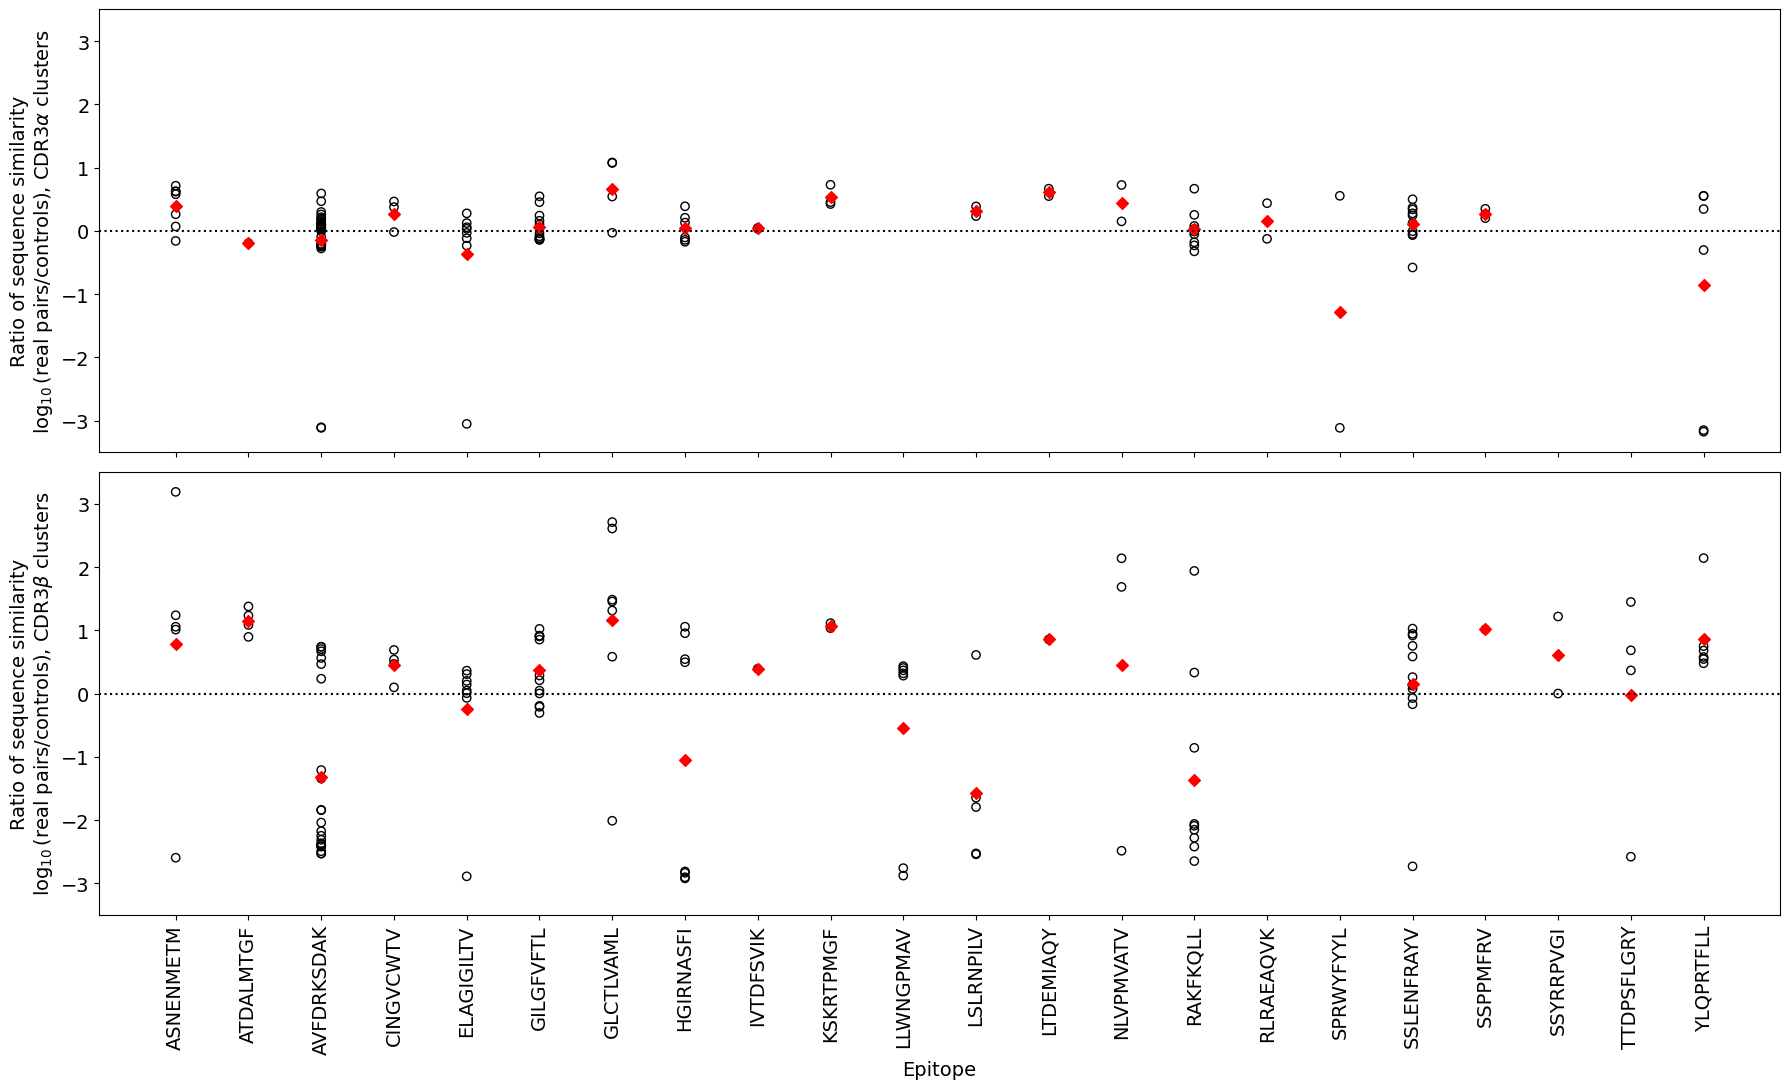

In [32]:
f, ax = plt.subplots(nrows=2, figsize=(18, 11), sharex=True, sharey=True)

for j, chain in enumerate(['b', 'a']):
    
    ticklist = []
    for i, ep in enumerate(sorted(list(ep_diffs[chain].keys()))):
        ticklist.append(ep)
        ax[j].scatter([i]*len(ep_diffs[chain][ep]), ep_diffs[chain][ep], facecolor = 'none', edgecolor = 'k')
        ax[j].scatter(i, np.mean(ep_diffs[chain][ep]), c='r', marker='D')
    
    ax[j].axhline(0, ls = ':', c = 'k')
ax[1].set_xticks(range(len(ticklist)), ticklist, rotation = 90, fontsize = 14)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = 14)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = 14)
ax[1].set_xlabel(r'Epitope', fontsize = 14)
ax[0].set_ylabel('Ratio of sequence similarity\n' r'$\log_{10}$(real pairs/controls), CDR3$\alpha$ clusters', fontsize = 14)
ax[1].set_ylabel('Ratio of sequence similarity\n' r'$\log_{10}$(real pairs/controls), CDR3$\beta$ clusters', fontsize = 14)
plt.tight_layout()
plt.savefig('figures/AllEps_ab_clustering_seqsim_diff.png',
                    bbox_inches='tight')
plt.show()

In [33]:
print(DF)

           0     set  clus          ep chain
0   0.074125    real     4  ELAGIGILTV     a
0   0.091098  random     4  ELAGIGILTV     a
1   0.130744  random     4  ELAGIGILTV     a
2   0.087039  random     4  ELAGIGILTV     a
3   0.095346  random     4  ELAGIGILTV     a
..       ...     ...   ...         ...   ...
95  0.000000  random    52   SPRWYFYYL     b
96  0.077850  random    52   SPRWYFYYL     b
97  0.140028  random    52   SPRWYFYYL     b
98  0.138013  random    52   SPRWYFYYL     b
99  0.069007  random    52   SPRWYFYYL     b

[24341 rows x 5 columns]


In [34]:
epdf = vdj.loc[vdj['Epitope'] == 'GLCTLVAML']
As = epdf['CDR3-a'].tolist()
Bs = epdf['CDR3-b'].tolist()
A_sim = pwdist.triplet_similarity(As)
B_sim = pwdist.triplet_similarity(Bs)
A_sim = A_sim[np.triu_indices(A_sim.shape[0], k = 1)]
B_sim = B_sim[np.triu_indices(B_sim.shape[0], k = 1)]

[1.6665069192135432e-34, 4.2822535421061975e-51, 5.285554495083984e-10, 4.2473648091309037e-07, 0.0, 0.0, 0.0, 1.753801590907083e-30, 1.858689919853224e-24]
['\n', '\n***', '\n***', '\n***', '\n***', '\n***', '\n***', '\n***', '\n***', '\n***']
[1.0, 5.418533148601444e-06, 0.9246971958532894, 1.3741403189429864e-05, 8.946525561014499e-44, 5.3442809528194585e-124, 0.0, 6.548285839900448e-15, 8.938389551988053e-154]
['\n', '\n', '\n***', '\n', '\n***', '\n***', '\n***', '\n***', '\n***', '\n***']


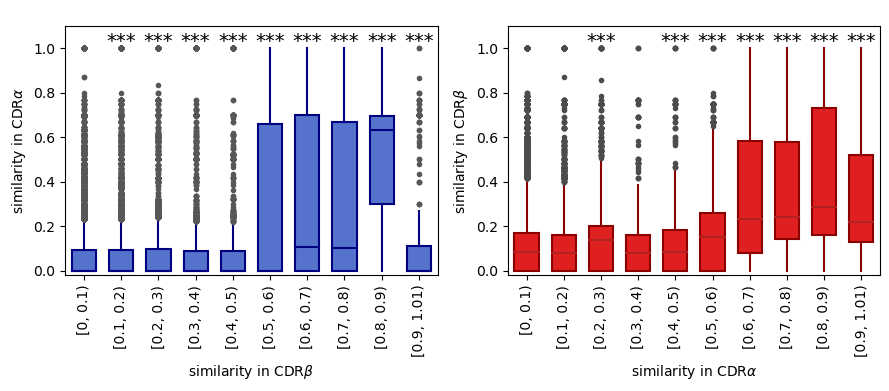

In [35]:
all_sims_a = []
all_sims_b = []
f,ax = plt.subplots(ncols=2, figsize = (9,4))
intervals = [(0,0.1),(0.1,0.2),(0.2,0.3),(0.3,0.4),(0.4,0.5),(0.5,0.6),(0.6,0.7),(0.7,0.8),(0.8,0.9),(0.9,1.01)]
intervals_txt = ['[' + str(x[0]) + ', ' + str(x[1]) + ')' for x in intervals]
for i, t in enumerate(intervals):
    asim = A_sim[(B_sim >= t[0]) & (B_sim < t[1])].ravel()
    bsim = B_sim[(A_sim >= t[0]) & (A_sim < t[1])].ravel()
    all_sims_a.append(asim)
    all_sims_b.append(bsim)

sns.boxplot(all_sims_a, ax=ax[0], color='royalblue', width=0.65,
            notch=False, showcaps=False, fliersize = 3,
            boxprops = {'edgecolor':'navy'},
            whiskerprops = {'color':'navy'},
            flierprops={"marker": "o"},
            medianprops={"color": "navy"})
sns.boxplot(all_sims_b, ax=ax[1], color='r', width=0.65,
            notch=False, showcaps=False, fliersize = 3,
            boxprops = {'edgecolor':'darkred'},
            whiskerprops = {'color':'darkred'},
            flierprops={"marker": "o"},
            medianprops={"color": "firebrick"})

t_tests = [ttest_ind(all_sims_a[i], all_sims_a[0], alternative='greater').pvalue for i in range(1,len(all_sims_a))]
pvals = ['\n'] + ['\n***' if x <0.001 else '\n**' if x <0.01 else '\n*' if x<0.05 else '\n' for x in t_tests]
# first pval empty because it's what we compare to
print(t_tests)
print(pvals)
for i,v in enumerate(pvals):
    ax[0].text(i,1.08,v,horizontalalignment='center',verticalalignment='center', fontsize=14)
ax[0].set_ylim(-0.02,1.1)

t_tests = [ttest_ind(all_sims_b[i], all_sims_b[0], alternative='greater').pvalue for i in range(1,len(all_sims_b))]
pvals = ['\n'] + ['\n***' if x <0.001 else '\n**' if x <0.01 else '\n*' if x<0.05 else '\n' for x in t_tests]
# first pval empty because it's what we compare to
print(t_tests)
print(pvals)
for i,v in enumerate(pvals):
    ax[1].text(i,1.08,v,horizontalalignment='center',verticalalignment='center', fontsize=14)
ax[1].set_ylim(-0.02,1.1)

ax[0].set_xticklabels(intervals_txt, rotation=90)
ax[0].set_xlabel(r'similarity in CDR$\beta$')
ax[1].set_xlabel(r'similarity in CDR$\alpha$')
ax[0].set_ylabel(r'similarity in CDR$\alpha$')
ax[1].set_ylabel(r'similarity in CDR$\beta$')
ax[1].set_xticklabels(intervals_txt, rotation=90)
plt.tight_layout()
plt.show()

In [36]:
from scipy.stats import spearmanr

/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.14824986333222026, 0.1499134353944339, 0.15430334996209194, nan, 0.15430334996209194]
corr1:  SpearmanrResult(correlation=0.7201115233494085, pvalue=0.018840489640104402)
corr2:  SpearmanrResult(correlation=0.9082951062292475, pvalue=0.0007023293638154311)


/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.029462782549439483, 0.06933752452815364, 0.07412493166611013, 0.08006407690254358, 0.08006407690254358, 0.3131121455425747, 0.7500000000000002, nan, 0.18896715847818296]
corr1:  SpearmanrResult(correlation=0.31707906532593416, pvalue=0.3720185798425297)
corr2:  SpearmanrResult(correlation=0.945614971893967, pvalue=0.00011709145944109084)
[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
corr1:  SpearmanrResult(correlation=0.6671418389769355, pvalue=0.035087277845410575)
corr2:  SpearmanrResult(correlation=nan, pvalue=nan)


/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333336, 0.09356706788701427, 0.14824986333222026, 0.19345305696776208, 0.16012815380508716]
corr1:  SpearmanrResult(correlation=0.480245379507251, pvalue=0.1600670096468279)
corr2:  SpearmanrResult(correlation=0.9245067028843873, pvalue=0.0001296326859155409)
[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.08770580193070293, 0.08703882797784893, 0.08770580193070293, 0.09090909090909091, 0.08703882797784893, 0.08362420100070908, 0.08084520834544431, 0.08058229640253803, 0.16116459280507606, 0.09834817412823685]
corr1:  SpearmanrResult(correlation=0.2392080280190373, pvalue=0.5056601006121273)
corr2:  SpearmanrResult(correlation=0.08536744066467457, pvalue=0.8146136789854659)
[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000

/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07142857142857144, nan, 0.0]
corr1:  SpearmanrResult(correlation=0.06293790933744675, pvalue=0.8628673905376141)
corr2:  SpearmanrResult(correlation=0.41079191812887456, pvalue=0.27207082745361133)


/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08006407690254358, 0.17541160386140586, 0.6153846153846154]
corr1:  SpearmanrResult(correlation=0.8703005051059519, pvalue=0.0022737783952579693)
corr2:  SpearmanrResult(correlation=0.812776759390954, pvalue=0.004259472986524341)
[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.08058229640253803, 0.0, 0.0, 0.08655256228011798, 0.09245003270420485, 0.10050378152592121, 0.10540925533894598, 0.10540925533894598, 0.05555555555555555, 0.08451542547285167]
corr1:  SpearmanrResult(correlation=0.1661735128220992, pvalue=0.6463679106753139)
corr2:  SpearmanrResult(correlation=0.43293487765656397, pvalue=0.21139056132554077)
[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333334, 0.0, 0.23076923076923078, nan, 0.07161148740394328]
corr1:  SpearmanrResult(correlation=0.1702135522304181, pvalue=0.6382593583672791)
corr2:  SpearmanrResult(correlation=0.693103280083672, pvalue=0.038441459345883014)


/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6923076923076924, 0.6363636363636364, 0.40724388109924003]
corr1:  SpearmanrResult(correlation=0.6694619270045784, pvalue=0.048568194944886824)
corr2:  SpearmanrResult(correlation=0.7531234192521683, pvalue=0.011914859098813412)
[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
corr1:  SpearmanrResult(correlation=-0.698093752539648, pvalue=0.0247638402783619)
corr2:  SpearmanrResult(correlation=nan, pvalue=nan)


/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0]
corr1:  SpearmanrResult(correlation=0.30014659175074676, pvalue=0.39944985658597365)
corr2:  SpearmanrResult(correlation=0.0, pvalue=1.0)
[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.07412493166611013, 0.0, 0.32789739862118217, 0.08362420100070908, 0.0]
corr1:  SpearmanrResult(correlation=0.6810328622452322, pvalue=0.03015088403187696)
corr2:  SpearmanrResult(correlation=0.5145100586970258, pvalue=0.12810991093231888)
[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.06900655593423542, 0.0668153104781061, 0.08006407690254358, 0.08006407690254358, 0.07715167498104597, 0.08333333333333336, 0.08333333333333336, 0.08333333333333336, 0.10683754591278005, 0

/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18181818181818182, 0.07142857142857144, 0.06900655593423542]
corr1:  SpearmanrResult(correlation=0.6686960980480711, pvalue=0.034509541651785346)
corr2:  SpearmanrResult(correlation=0.7531234192521683, pvalue=0.011914859098813412)


/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.05, 0.15000000000000002, 0.25, 0.35, 0.45, 0.55, 0.6499999999999999, 0.75, 0.8500000000000001, 0.9550000000000001] [0.0, 0.0, 0.0, 0.0, 0.17541160386140586, 0.1825741858350554, 0.1825741858350554, 0.1825741858350554, nan, 0.15811388300841897]
corr1:  SpearmanrResult(correlation=0.7134278969833519, pvalue=0.020521411876850356)
corr2:  SpearmanrResult(correlation=0.7625264197918018, pvalue=0.01688204072858314)


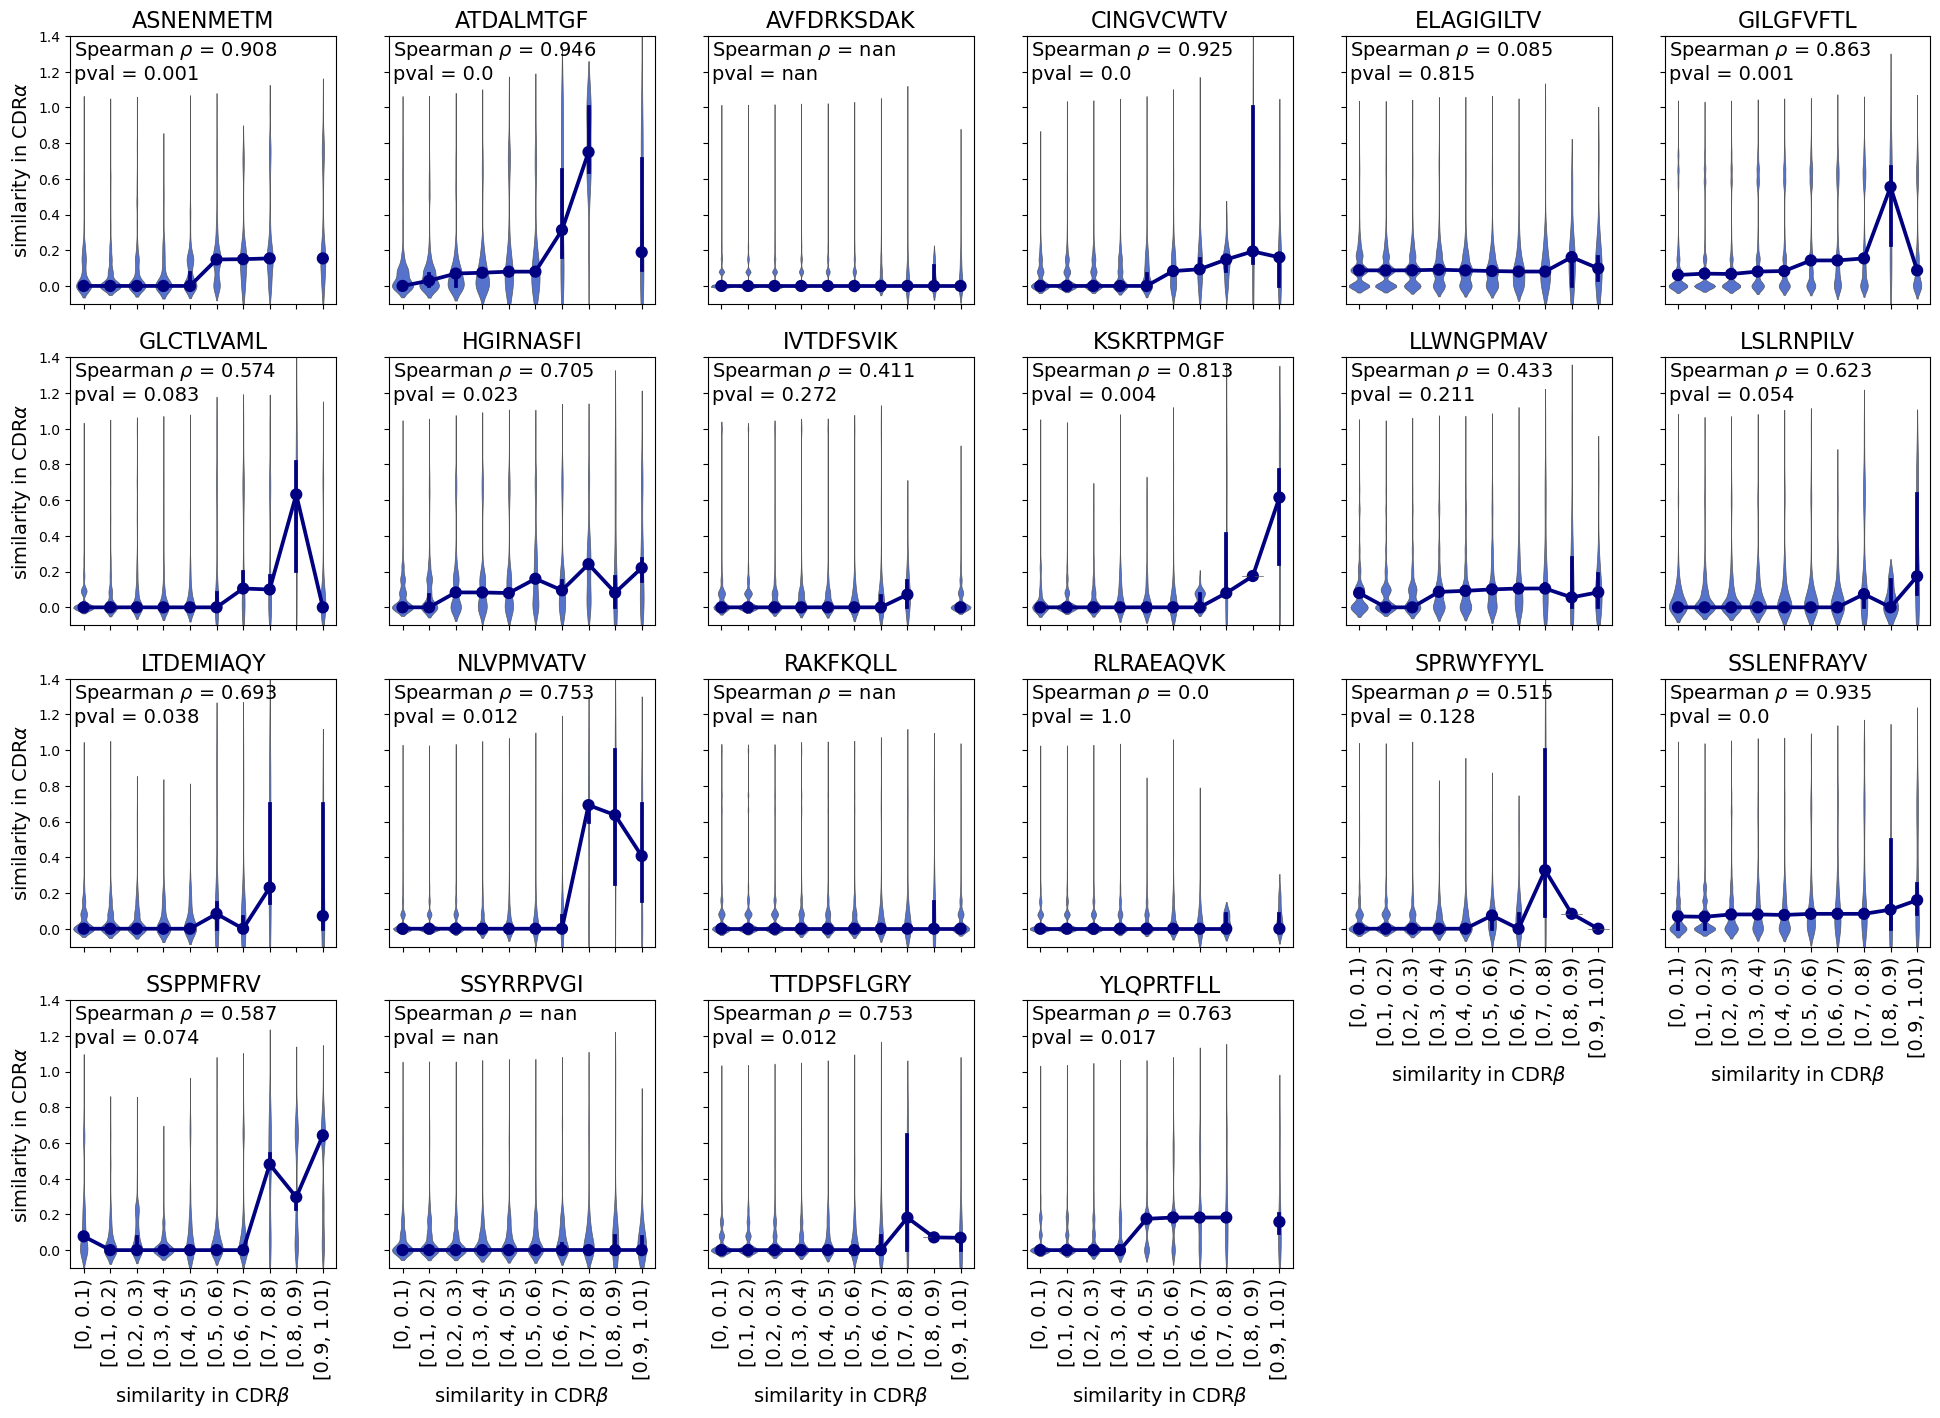

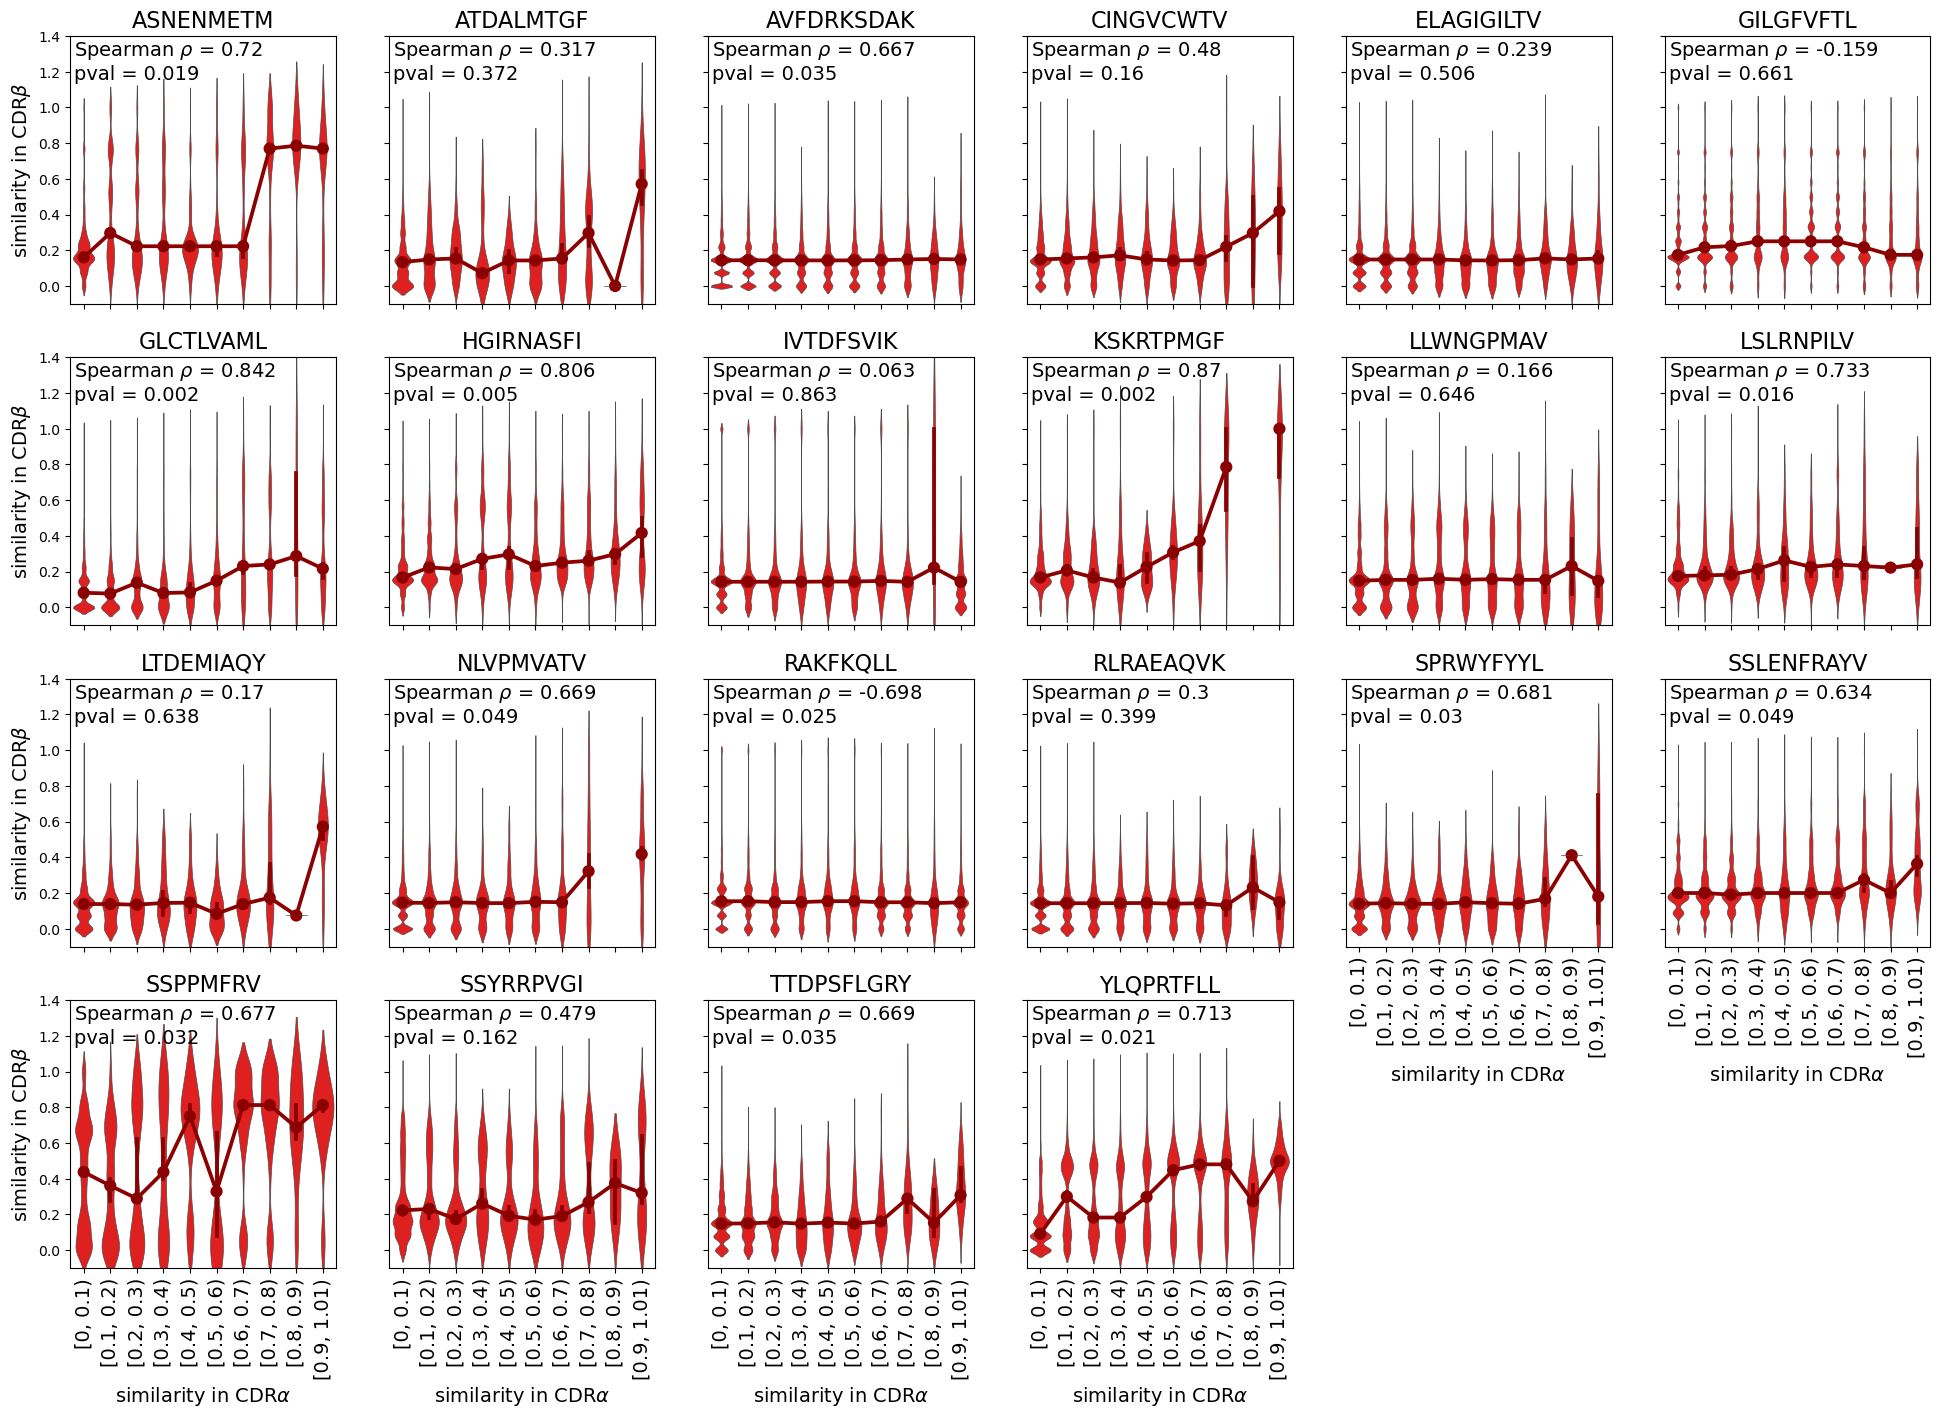

In [37]:
f,ax = plt.subplots(ncols=6, nrows=4, figsize = (24,16), sharex=True, sharey=True)
axs = ax.ravel()
f1,ax1 = plt.subplots(ncols=6, nrows=4, figsize = (24,16), sharex=True, sharey=True)
axs1 = ax1.ravel()

intervals = [(0,0.1),(0.1,0.2),(0.2,0.3),(0.3,0.4),(0.4,0.5),(0.5,0.6),(0.6,0.7),(0.7,0.8),(0.8,0.9),(0.9,1.01)]
intervals_txt = ['[' + str(x[0]) + ', ' + str(x[1]) + ')' for x in intervals]

for j,ep in enumerate(sorted(vdj['Epitope'].unique().tolist())):
    epdf = vdj.loc[vdj['Epitope'] == ep]
    As = epdf['CDR3-a'].tolist()
    Bs = epdf['CDR3-b'].tolist()
    A_sim = pwdist.triplet_similarity(As)
    B_sim = pwdist.triplet_similarity(Bs)
    A_sim = A_sim[np.triu_indices(A_sim.shape[0], k = 1)]
    B_sim = B_sim[np.triu_indices(B_sim.shape[0], k = 1)]

    all_sims_a = []
    all_sims_b = []
    midpoints_a = []
    midpoints_b = []
    medians_a = []
    medians_b = []
    
    for i, t in enumerate(intervals):
        asim = A_sim[(B_sim >= t[0]) & (B_sim < t[1])].ravel()
        bsim = B_sim[(A_sim >= t[0]) & (A_sim < t[1])].ravel()
        all_sims_a.append(asim)
        all_sims_b.append(bsim)
        midpoints_a.append((t[0] + t[1])/2)
        midpoints_b.append((t[0] + t[1])/2)
        medians_a.append(np.median(asim))
        medians_b.append(np.median(bsim))

    sns.violinplot(all_sims_a, ax=axs[j], color='royalblue',
                linewidth=0.5, inner=None, alpha=0.5)
    sns.pointplot(all_sims_a, estimator='median', errorbar=('ci', 95), ax=axs[j], color='navy')
    sns.violinplot(all_sims_b, ax=axs1[j], color='r',
                linewidth=0.5, inner=None, alpha=0.5)
    sns.pointplot(all_sims_b, estimator='median', errorbar=('ci', 95), ax=axs1[j], color='darkred')
    # axs[j].set_ylim(-0.1,1.2)
    # axs1[j].set_ylim(-0.1,1.2)

    # calculate t-test: is the bin higher than the bin at 0?
    # t_tests = [ttest_ind(all_sims_a[i], all_sims_a[0], alternative='greater').pvalue for i in range(1,len(all_sims_a))]
    # pvals = ['\n'] + ['\n***' if x <0.001 else '\n**' if x <0.01 else '\n*' if x<0.05 else '\n' for x in t_tests]
    # first pval empty because it's what we compare to
    # for i,v in enumerate(pvals):
    #     axs[j].text(i,1.1,v,horizontalalignment='center',verticalalignment='center', fontsize=10)

    # t_tests = [ttest_ind(all_sims_b[i], all_sims_b[0], alternative='greater').pvalue for i in range(1,len(all_sims_b))]
    # pvals = ['\n'] + ['\n***' if x <0.001 else '\n**' if x <0.01 else '\n*' if x<0.05 else '\n' for x in t_tests]
    # # first pval empty because it's what we compare to
    # for i,v in enumerate(pvals):
    #     axs1[j].text(i,1.1,v,horizontalalignment='center',verticalalignment='center', fontsize=10)

    # spearman between mid point of bin and median
    print(midpoints_b, medians_a)
    corr_ab = spearmanr(midpoints_a, medians_b, nan_policy = 'omit')
    corr_ba = spearmanr(midpoints_b, medians_a, nan_policy = 'omit')
    print('corr1: ', corr_ab)
    print('corr2: ', corr_ba)

    axs[j].text(-0.35,1.38, r'Spearman $\rho$ = ' + str(round(corr_ba.correlation, 3)) + '\npval = ' + str(round(corr_ba.pvalue,3)), fontsize=14, va='top')
    axs[j].set_ylim(-0.1,1.4)
    axs1[j].text(-0.35,1.38, r'Spearman $\rho$ = ' + str(round(corr_ab.correlation, 3)) + '\npval = ' + str(round(corr_ab.pvalue,3)), fontsize=14, va='top')
    axs1[j].set_ylim(-0.1,1.4)


    if j in [0,6,12,18]:
        axs[j].set_ylabel(r'similarity in CDR$\alpha$', fontsize=14)
        axs1[j].set_ylabel(r'similarity in CDR$\beta$', fontsize=14)
    if j > 15:
        axs[j].set_xticklabels(intervals_txt, rotation=90, fontsize=14)
        axs[j].xaxis.set_tick_params(which='both', labelbottom=True, rotation=90)
        axs[j].set_xlabel(r'similarity in CDR$\beta$', fontsize=14)
        axs1[j].set_xlabel(r'similarity in CDR$\alpha$', fontsize=14)
        axs1[j].set_xticklabels(intervals_txt, rotation=90, fontsize=14)
        axs1[j].xaxis.set_tick_params(which='both', labelbottom=True, rotation=90)
    axs[j].set_title(ep, fontsize=16)
    axs1[j].set_title(ep, fontsize=16)

axs[-2].axis('off')
axs[-1].axis('off')
axs1[-2].axis('off')
axs1[-1].axis('off')
# plt.tight_layout()
f.savefig('figures/triplet_similarity_correlation_alleps_beta.png',
                    bbox_inches='tight')
f1.savefig('figures/triplet_similarity_correlation_alleps_alpha.png',
                    bbox_inches='tight')

plt.show()